In [2]:
# data manipulation 
import numpy as np
import pandas as pd



from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from fbprophet import Prophet
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
import prep
from model import next_two_weeks_Holt, prep_prophet_data1, prep_steps_data2, prep_steps_data3, steps_prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Acquire and prep
Acquire consolidate all the csv files, delete the nutrition related data.
Prep changed any strings/ints to floats.

In [3]:
#consolidate all the csv files of fitbit data
df= acquire.get_df()
#Clean data: format date, format other columns for predicitons
df= prep.prep_df()
target_vars=['Steps', 'Calories_Burned', 'Activity_Calories']
df=df.rename(columns={'Calories Burned':'Calories_Burned', "Activity Calories": "Activity_Calories"})
df.head()

,Date,Calories_Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity_Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


Target Variables:
    Steps
    Calories Burned
    Activity Calories

### Split Data 

In [4]:
#split data for train and test, using 66% of the data for a train and 33% for test
train, test= prep.test_train_split(df, .66)
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 148
Testing Observations: 77


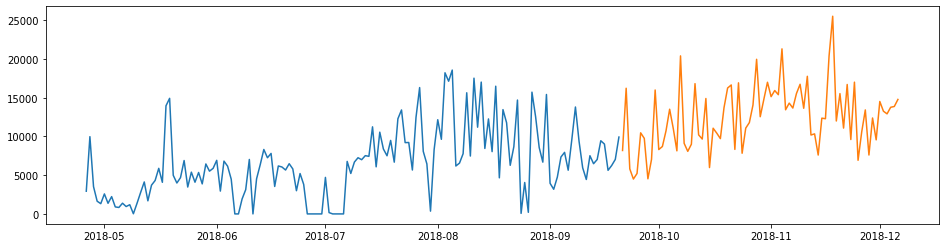

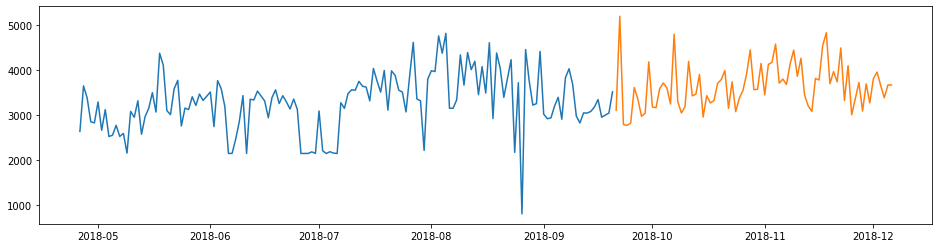

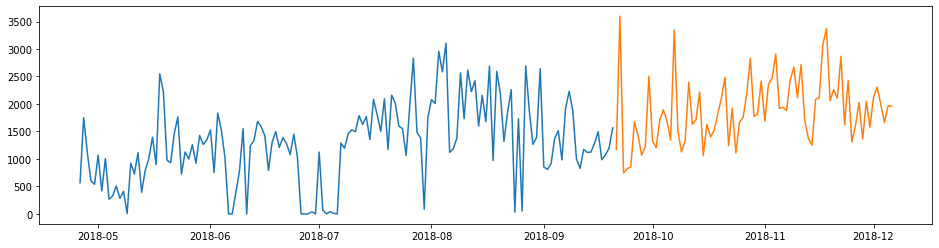

In [5]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [6]:
#Needed Functions
    #1. Evaluate()- will compute the Mean Squared Error and the Rood Mean Squared Error
    #2. plot_and_eval()- will use evaluate function and plot a comparison of train and test 

def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


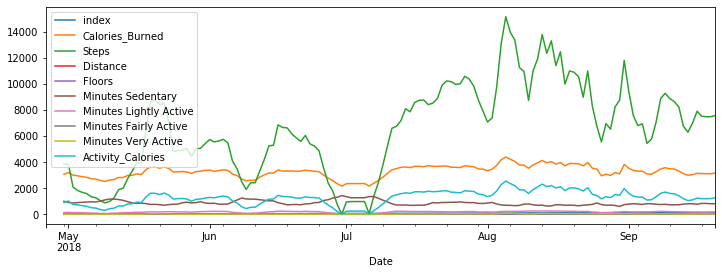

In [7]:
### Moving Average
train.rolling(5).mean().plot(figsize=(12, 4))
plt.show()

## Simple Average- 
Used as our BASELINE to compare with our predictions

In [7]:
yhat = pd.DataFrame(test[target_vars])
for var in target_vars:
    yhat[var] = train[var].mean()
yhat.head()

,Steps,Calories_Burned,Activity_Calories
Date,,,
2018-09-21,6482.236486,3271.871622,1273.0
2018-09-22,6482.236486,3271.871622,1273.0
2018-09-23,6482.236486,3271.871622,1273.0
2018-09-24,6482.236486,3271.871622,1273.0
2018-09-25,6482.236486,3271.871622,1273.0


Steps -- MSE: 53133261.42 RMSE: 7289.26
Calories_Burned -- MSE: 398966.03 RMSE: 631.64
Activity_Calories -- MSE: 742610.47 RMSE: 861.75


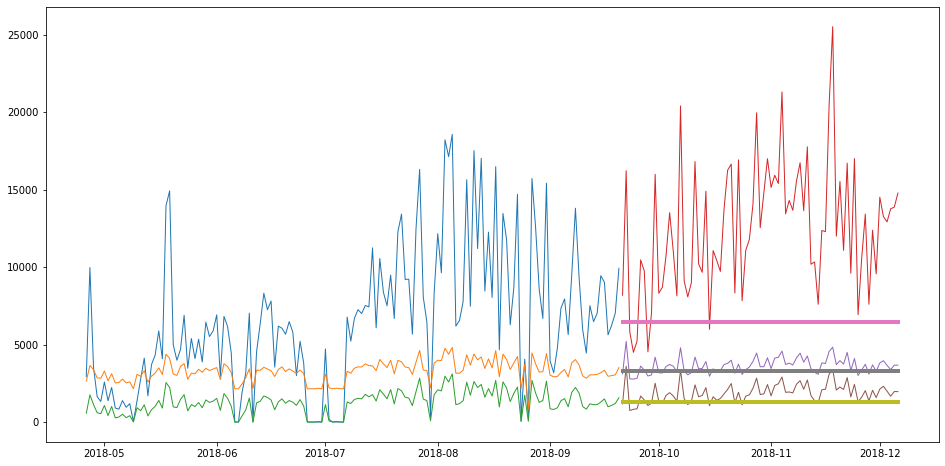

In [8]:
#baseline
plot_and_eval(target_vars, train = train, test = test)

## Holt's Linear Trend
Use the Holt to predict the needed future two weeks

In [9]:
next_two_weeks_Holt(df)

,Calories_Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity_Calories
2018-12-07,3587.472100,13585.304102,6.435701,9.654620,694.307013,208.806811,12.007653,64.611709,1887.870661
2018-12-08,3580.626709,13671.018509,6.462914,9.398874,698.961113,205.429933,11.587490,65.558456,1879.472303
2018-12-09,3573.781319,13756.732916,6.490128,9.143128,703.615214,202.053055,11.167326,66.505202,1871.073946
2018-12-10,3566.935928,13842.447323,6.517341,8.887381,708.269315,198.676177,10.747163,67.451949,1862.675589
2018-12-11,3560.090537,13928.161730,6.544555,8.631635,712.923416,195.299298,10.326999,68.398695,1854.277232
2018-12-12,3553.245146,14013.876137,6.571768,8.375889,717.577516,191.922420,9.906836,69.345442,1845.878875
2018-12-13,3546.399755,14099.590544,6.598981,8.120143,722.231617,188.545542,9.486672,70.292189,1837.480517
2018-12-14,3539.554365,14185.304951,6.626195,7.864397,726.885718,185.168664,9.066509,71.238935,1829.082160
2018-12-15,3532.708974,14271.019359,6.653408,7.608651,731.539819,181.791786,8.646345,72.185682,1820.683803
2018-12-16,3525.863583,14356.733766,6.680622,7.352905,736.193920,178.414908,8.226182,73.132429,1812.285446


### Using Prophet to project future two weeks

In [17]:
#Steps
df1=prep_prophet_data1(df)
df1=df1.reset_index()
#Calories Burned
df2=prep_steps_data2(df)
df2=df2.reset_index()
#Activity Calories
df3=prep_steps_data3(df) 
df3=df3.reset_index()

In [18]:
#Steps
steps_prophet(df1)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
225,2018-12-07,14493.792069,10392.110003,19781.159522,14493.792069,14493.792069,436.895474,436.895474,436.895474,436.895474,436.895474,436.895474,0.0,0.0,0.0,14930.687543
226,2018-12-08,14546.332971,10780.774794,20245.004537,14546.332971,14546.332971,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,0.0,0.0,0.0,15626.877137
227,2018-12-09,14598.873873,10561.879238,20707.365122,14598.873872,14598.873875,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,0.0,0.0,0.0,15979.181046
228,2018-12-10,14651.414776,8310.048123,18289.303847,14651.414773,14651.414779,-1302.086898,-1302.086898,-1302.086898,-1302.086898,-1302.086898,-1302.086898,0.0,0.0,0.0,13349.327877
229,2018-12-11,14703.955678,9206.710990,18859.415753,14703.955673,14703.955684,-748.415319,-748.415319,-748.415319,-748.415319,-748.415319,-748.415319,0.0,0.0,0.0,13955.540359
230,2018-12-12,14756.496580,8576.657658,18619.840688,14756.496573,14756.496589,-1059.526053,-1059.526053,-1059.526053,-1059.526053,-1059.526053,-1059.526053,0.0,0.0,0.0,13696.970527
231,2018-12-13,14809.037482,10057.809384,19872.878945,14809.037472,14809.037494,212.281458,212.281458,212.281458,212.281458,212.281458,212.281458,0.0,0.0,0.0,15021.318940
232,2018-12-14,14861.578384,10248.561650,20594.691090,14861.578371,14861.578399,436.895474,436.895474,436.895474,436.895474,436.895474,436.895474,0.0,0.0,0.0,15298.473858
233,2018-12-15,14914.119286,11043.996280,20899.906719,14914.119270,14914.119304,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,0.0,0.0,0.0,15994.663452
234,2018-12-16,14966.660189,11415.435766,21333.058773,14966.660167,14966.660210,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,0.0,0.0,0.0,16346.967361


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
